# Linear Elasticity

*Authors:* 
 - *Laura De Lorenzis (ETH Zürich)*
 - *Corrado Maurini (corrado.maurini@sorbonne-universite.fr)*

This notebook serves as a tutorial to solve a problem of linear elasticity using DOLFINx (FEniCS).

You can find a tutorial and useful resources for DOLFINx at the following links

- https://docs.fenicsproject.org/
- https://github.com/FEniCS/dolfinx/
- https://jorgensd.github.io/dolfinx-tutorial/, see https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity.html for linear elasticity

We consider an elastic slab $\Omega$ with a straight crack $\Gamma$ subject to a mode-I loading by an applied traction force $f$, see figure. 

Using the symmetry, we will consider only half of the domain in the computation.

![title](./domain.png)

We solve the problem of linear elasticity with the finite element method, implemented using DOLFINx.

DOLFINx is advanced library that allows for efficient parallel computation. For the sake of simplicity, we assume here to work on a single processor and will not use MPI-related commands. Using DOLFINx with MPI will be covered in the afternoon session.

We start importing the required libraries. 

In [44]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import dolfinx.fem as fem
import dolfinx.mesh as mesh
import dolfinx.io as io
import dolfinx.plot as plot
import ufl

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

Let us generate a mesh using gmsh (http://gmsh.info/). 
The mesh is refined around the crack tip.
The function to generate the mesh is reported in the external file `meshes.py` located in the directory `python`.
To import it, we add `python` to the path where the system is looking for functions to import

In [45]:
import sys
sys.path.append("../utils")
from meshes import generate_mesh_with_crack

In [91]:
Lx = 1.
Ly = 0.5
Lcrack = 0.3
lc =.05
dist_min = .1
dist_max = .3
msh, mt, ft = generate_mesh_with_crack(
        Lcrack=Lcrack,
        Ly=Ly,
        lc=lc,  # caracteristic length of the mesh
        refinement_ratio=10,  # how much it is refined at the tip zone
        dist_min=dist_min,  # radius of tip zone
        dist_max=dist_max,  # radius of the transition zone
        verbosity=1
    )

To plot the mesh we use `pyvista` see:
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/main/python/demos/pyvista/demo_pyvista.py.html

In [92]:
import pyvista
pyvista.start_xvfb(wait=0.5)
grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(msh))
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.camera_position = 'xy'
#if not pyvista.OFF_SCREEN:
#    plotter.show()

## Finite element function space

We use here linear Lagrange triangle elements

In [93]:
element = ufl.VectorElement('Lagrange',msh.ufl_cell(),degree=1,dim=2)
V = fem.FunctionSpace(msh, element)

## Dirichlet boundary conditions

We define below the functions to impose the Dirichlet boundary conditions.

In our case we want to 
- block the vertical component $u_1$ of the displacement on the part of the bottom boundary without crack
- block the horizontal component $u_0$ on the right boundary

We first get the facets to block on the boundary (`dolfinx.mesh.locate_entities_boundary`) and then the corresponding dofs (`dolfinx.fem.locate_dofs_topological`)

In [94]:
def bottom_no_crack(x):
    return np.logical_and(np.isclose(x[1], 0.0), 
                          x[0] > Lcrack)

def top(x):
    return np.isclose(x[1], Ly)

In [95]:
bottom_no_crack_facets = mesh.locate_entities_boundary(msh, msh.topology.dim-1, bottom_no_crack)
bottom_no_crack_dofs_y = fem.locate_dofs_topological(V.sub(1), msh.topology.dim-1, bottom_no_crack_facets)

top_facets = mesh.locate_entities_boundary(msh, msh.topology.dim-1, top)
top_dofs = fem.locate_dofs_topological(V, msh.topology.dim-1, top_facets)
top_dofs

array([  1,   5,  12,  30,  45,  58,  71,  84,  98, 114, 131, 150, 169,
       191, 214, 237, 262, 295, 330, 367, 413], dtype=int32)

The following lines define the `dolfinx.fem.dirichletbc` objects. We impose a zero displacement.

In [96]:
bc_bottom = fem.dirichletbc(ScalarType(0), bottom_no_crack_dofs_y, V.sub(1))
bc_top = fem.dirichletbc(np.array([0,1/2],dtype=ScalarType), top_dofs, V)
bcs = [bc_bottom, bc_top]

## Define the bulk and surface mesures
The bulk (`dx`) and surface (`ds`) measures are used by `ufl` to write variational form with integral over the domain or the boundary, respectively. 

In this example the surface measure `ds` includes tags to specify Neumann bcs: `ds(1)` will mean the integral on the top boundary. 

In [97]:
dx = ufl.Measure("dx",domain=msh)
top_facets = mesh.locate_entities_boundary(msh, 1, lambda x : np.isclose(x[1], Ly))
mt = mesh.meshtags(msh, 1, top_facets, 1)
ds = ufl.Measure("ds", subdomain_data=mt)

## Define the variational problem 

We specify the problem to solve though the weak formulation written in the [ufl](https://fenics.readthedocs.io/projects/ufl/en/latest/) syntax by giving the bilinear $a(u,v)$ and linear forms $L(v)$ in 
the weak formulation: 

find the *trial function* $u$ such that for all *test function* $v$
$a(u,v)=L(v)$ with 

$$
a(u,v)=\int_{\Omega\setminus\Gamma}\sigma(\varepsilon(u))\cdot \varepsilon(v)\,\mathrm{d}x, 
\quad L(v)=\int_\Omega b\cdot v \,\mathrm{d}x + \int_{\partial_N\Omega} f\cdot v \,\mathrm{d}s 
$$

Note on UFL terminology:
- `ufl.inner(sigma(eps(u)), eps(v))` is an expression
- `ufl.inner(sigma(eps(u)), eps(v)) * dx` is a form

In [98]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

E = 1. 
nu = 0.3 
mu = E / (2.0 * (1.0 + nu))
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
# this is for plane-stress
lmbda = 2 * mu * lmbda / ( lmbda + 2 * mu )

def eps(u):
    """Strain"""
    return ufl.sym(ufl.grad(u))

def sigma(eps):
    """Stress"""
    return 2.0 * mu * eps + lmbda * ufl.tr(eps) * ufl.Identity(2)

def a(u,v):
    """The bilinear form of the weak formulation"""
    return ufl.inner(sigma(eps(u)), eps(v)) * dx 

def L(v): 
    """The linear form of the weak formulation"""
    # Volume force
    b = fem.Constant(msh,ScalarType((0, 0)))

    # Surface force on the top
    f = fem.Constant(msh,ScalarType((0, 0.)))
    return ufl.dot(b, v) * dx + ufl.dot(f, v) * ds(1)

Let us plot the solution using `pyvista`, see
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/v0.5.0/python/demos/demo_pyvista.html

## Define the linear problem and solve
We solve the problem using a direct solver. The class `dolfinx.fem.LinearProblem` assemble the stiffness matrix and load vector, apply the boundary conditions, and solve the linear system.

In [99]:
problem = fem.petsc.LinearProblem(a(u,v), L(v), bcs=bcs, 
                                    petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()
uh.name = "displacement"

## Postprocessing

We can easily calculate the potential energy

In [100]:
energy = fem.assemble_scalar(fem.form(0.5 * a(uh, uh) - L(uh)))
print(f"The potential energy is {energy:2.3e}")

The potential energy is 2.026e-01


We can save the results to a file, that we can open with `paraview` (https://www.paraview.org/)

In [101]:
with io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo.xdmf", "w") as file:
    file.write_mesh(uh.function_space.mesh)
    file.write_function(uh)

## Stress computation

We calculate here the Von Mises stress by interpolating the corresponding ufl expression, see https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html#stress-computation

In [102]:
sigma_iso = 1./3*ufl.tr(sigma(eps(uh)))*ufl.Identity(len(uh))
sigma_dev =  sigma(eps(uh)) - sigma_iso
von_Mises = ufl.sqrt(3./2*ufl.inner(sigma_dev, sigma_dev))
V_von_mises = fem.FunctionSpace(msh, ("DG", 0))
stress_expr = fem.Expression(von_Mises, V_von_mises.element.interpolation_points())
vm_stress = fem.Function(V_von_mises)
vm_stress.interpolate(stress_expr)


Your build of VTK does not have the proper web modules enabled.
These modules are typically enabled by default with the
`-DVTK_GROUP_ENABLE_Web:STRING=WANT` build flag.

Conda users: This is a known issue with the conda-forge VTK feedstock.
See https://github.com/conda-forge/vtk-feedstock/pull/258


Falling back to a static output.
  warnings.warn(



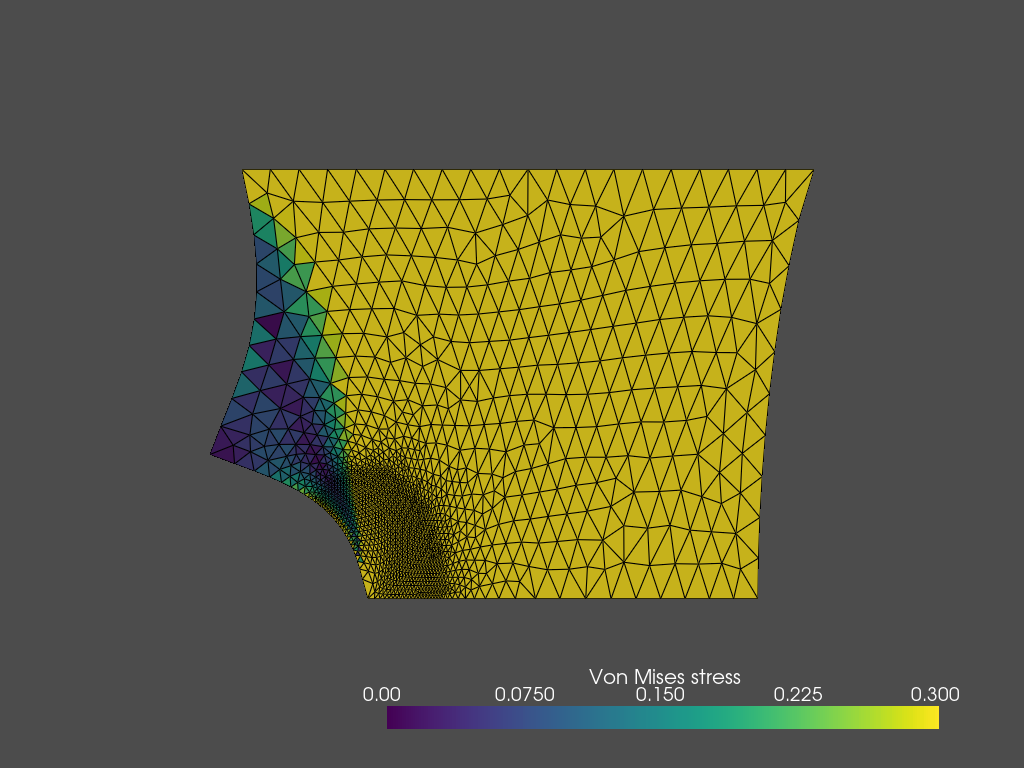

In [103]:
from plots import warp_plot_2d
plotter = warp_plot_2d(uh,cell_field=vm_stress,
                       field_name="Von Mises stress",
                       factor=.5,
                       show_edges=True,
                       clim=[0, 0.3])

#if not pyvista.OFF_SCREEN:
#    plotter.show()

We can now wrap all the code in a the external module, so that we can resuse the solver later

We define in `elastic_solver.py` a function `solve_elasticity` taking as input  the crack length `Lcrack`, the geoemtric and mesh parameters, the Poisson ratio `nu`, and giving us as output the solution field `uh` and the related potential energy `energy`

The returned `uh` and `energy` will be calculated assuming a force density `f=1` on the top surface and a Young modulus `E=1`. This is without loss of generality, see the exercise below.


**Exercise.** 

Let be $u^{*}$ and $P^{*}$ the displacement field obtained on a domain $\Omega^*=[0,1]\times[0,\varrho]$ for a Young module $E^*=1$ and a load $f^*=1$ applied on the top surface. 
Determine by dimensional analysis the analytical formulas giving the 
displacement $u$ and the potential energy $P$ for any other value of  $E$,  load $f$, and for any domain $\Omega=[0,L]\times[0,\varrho\, L]$  obtained by a rescaling of $\Omega^*$ with a length-scale $L$.
Deduce that we can, without loss of generality, perform computation with $E=1$, $f=1$ and $L=1$.

In [43]:
from mpi4py import MPI
from elastic_solver import solve_elasticity

uh, energy, _ = solve_elasticity(
    nu=0.3,
    E=1,
    load=1,
    Lx=1,
    Ly=0.5,
    Lcrack=0.3,
    lc=0.1,
    refinement_ratio=10,
    dist_min=0.2,
    dist_max=0.3,
    verbosity=1
)

with io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo.xdmf", "w") as file:
    file.write_mesh(uh.function_space.mesh)
    file.write_function(uh)


The potential energy for Lcrack=3.000e-01 is -4.175e-01
